In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Processes for Images

This notebook contains examples of Neural Processes for images and how these can be used for various tasks like inpainting.

### Load a trained model

In [2]:
import json
from neural_process import NeuralProcessImg

# Load config file for celebA model
folder = 'caligraphy'
config_file = folder + '/config.json'
model_file = folder + '/model.pt'

with open(config_file) as f:
    config = json.load(f)

# Load trained model
model = NeuralProcessImg(config["img_size"], 
                         config["r_dim"], 
                         config["h_dim"], 
                         config["z_dim"]).to(device)
model.load_state_dict(torch.load(model_file, map_location=lambda storage, loc: storage))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

### Visualize some CelebA samples

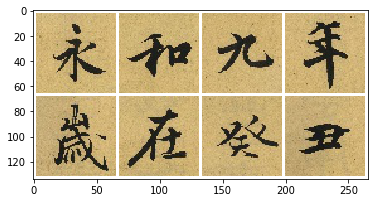

In [4]:
import imageio
from torchvision.utils import make_grid

# Read images into torch.Tensor
all_imgs = torch.zeros(8, 3, 64, 64)

for i in range(8):
    img = imageio.imread('characters/s{}.jpg'.format(i + 1))
    all_imgs[i] = torch.Tensor(img.transpose(2, 0, 1) / 255.)

# Visualize sample on a grid
img_grid = make_grid(all_imgs, nrow=4, pad_value=1.)
plt.imshow(img_grid.permute(1, 2, 0).numpy())

### Inpainting images with Neural Processes

Inpainting is the task of inferring missing pixels in a partially occluded image. Here we show examples of how Neural Processes can be used to solve this problem.

#### Occluding image

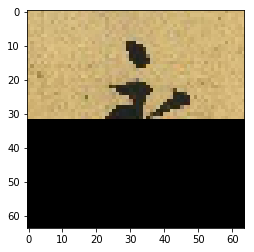

In [6]:
# Select one of the images to perform inpainting
img = all_imgs[0]

# Define a binary mask to occlude image. For Neural Processes,
# the context points will be defined as the visible pixels
context_mask = torch.zeros((64, 64)).byte()
context_mask[:32, :] = 1  # Top half of pixels are visible

# Show occluded image
occluded_img = img * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

#### Generating inpaintings

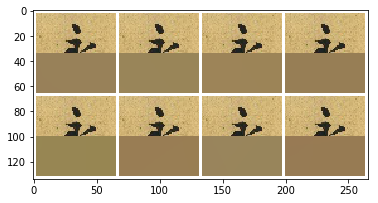

In [7]:
from utils import inpaint

num_inpaintings = 8  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 3, 64, 64)

# Sample several inpaintings
for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, img, context_mask, device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
plt.imshow(inpainting_grid.permute(1, 2, 0).numpy())

As can be seen, the inpaintings match the context pixels and are fairly diverse.

#### Different masks

We can use a variety of masks and image to test the model.

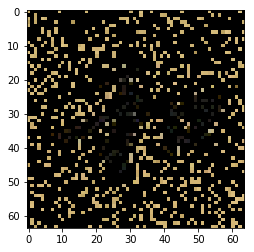

In [18]:
# Select one of the images to perform inpainting
img = all_imgs[1]

# Define a random mask
context_mask = torch.Tensor(64, 64).uniform_() > 0.8

# Visualize occluded image
occluded_img = img * context_mask.float()
plt.imshow(occluded_img.permute(1, 2, 0).numpy())

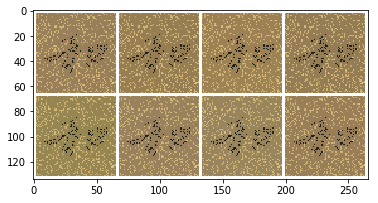

In [19]:
num_inpaintings = 8  # Number of inpaintings to sample from model
all_inpaintings = torch.zeros(num_inpaintings, 3, 64, 64)

# Sample several inpaintings
for i in range(num_inpaintings):
    all_inpaintings[i] = inpaint(model, img, context_mask, device)

# Visualize inpainting results on a grid
inpainting_grid = make_grid(all_inpaintings, nrow=4, pad_value=1.)
grid_as_np = inpainting_grid.permute(1, 2, 0).numpy()
# If NP returns out of range values for pixels, clip values
plt.imshow(np.clip(grid_as_np, 0, 1))